# Import Libraries:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Upload Cleaned_test_data, Cleaned_train_data and Cleaned_store_data:

In [2]:
cleaned_test_data = pd.read_csv(r"C:/Users/HP/Desktop/Digi-crome/Project-6/Data/cleaned_test_data.csv")
cleaned_train_data = pd.read_csv(r"C:/Users/HP/Desktop/Digi-crome/Project-6/Data/cleaned_train_data.csv")
cleaned_store_data = pd.read_csv(r"C:/Users/HP/Desktop/Digi-crome/Project-6/Data/cleaned_store_data.csv")

# 1. Isolate the Rossmann Store Sales dataset into time series data:

In [3]:
# Ensure the 'Date' column is a datetime type
cleaned_train_data['Date'] = pd.to_datetime(cleaned_train_data['Date'])
cleaned_test_data['Date'] = pd.to_datetime(cleaned_test_data['Date'])

In [4]:
Rossmann_data = cleaned_train_data.groupby("Date").agg({"Sales": "mean"})
Rossmann_data.head(10)

,Sales
Date,
2013-01-01,46.001802
2013-01-02,5882.744361
2013-01-03,5442.977737
2013-01-04,5724.238889
2013-01-05,5073.330250
2013-01-06,44.536585
2013-01-07,8671.109375
2013-01-08,7400.097050
2013-01-09,6650.359739


# 2.  Check whether your time Series Data is Stationary:

In [5]:
from statsmodels.tsa.stattools import adfuller

In [6]:
adfResult = adfuller(Rossmann_data.Sales.values, autolag='AIC')

In [7]:
print(f'ADF Statistic: {adfResult[0]}')
print(f'p-value: {adfResult[1]}')

for key, value in adfResult[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -5.847753441313356
p-value: 3.64963500344566e-07
Critial Values:
   1%, -3.4374778690219956
Critial Values:
   5%, -2.864686684217556
Critial Values:
   10%, -2.5684454926748583


# 3. Depending on your conclusion from 2 above difference your time series data:

In [8]:
# Create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

In [9]:
Rossmann_data_diff = difference(Rossmann_data.Sales.values)
print(Rossmann_data_diff)

0      5836.742559
1      -439.766624
2       281.261152
3      -650.908639
4     -5028.793664
          ...     
936    8711.571031
937   -1026.863253
938    -479.046891
939     207.084022
940     956.851157
Length: 941, dtype: float64


# 4. Check for autocorrelation and partial autocorrelation of your data:

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

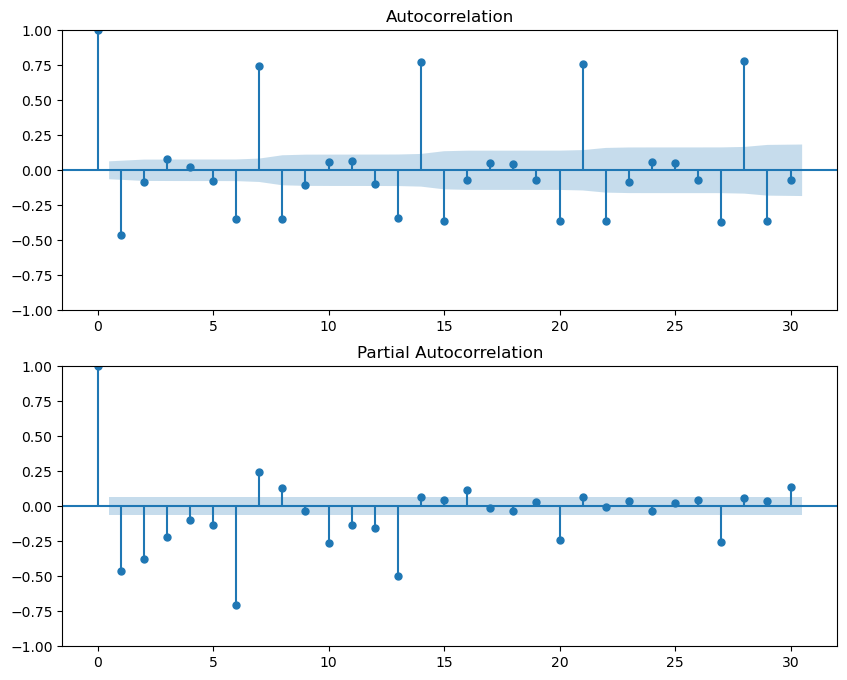

In [11]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(Rossmann_data_diff, ax=ax[0])
plot_pacf(Rossmann_data_diff, ax=ax[1])
plt.show()

# 5. Scale your data in the (-1, 1) range:

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(Rossmann_data)
Rossmann_data['SalesScaled'] = scaled_data
Rossmann_data.tail(10)

,Sales,SalesScaled
Date,,
2015-07-22,5289.280847,0.017809
2015-07-23,5776.896488,0.111935
2015-07-24,5729.908756,0.102865
2015-07-25,5192.597606,-0.000854
2015-07-26,88.465517,-0.986118
2015-07-27,8800.036548,0.695499
2015-07-28,7773.173295,0.497281
2015-07-29,7294.126404,0.404810
2015-07-30,7501.210427,0.444784


# 6. Transform the time series data into supervised learning data:

In [13]:
SIZE = len(Rossmann_data.SalesScaled)
WINDOW_SIZE = 48
BATCH_SIZE = SIZE - WINDOW_SIZE * 2
EPOCHS = 100

In [14]:
DateTrain = Rossmann_data.index.values[0:BATCH_SIZE]
DateValid = Rossmann_data.index.values[BATCH_SIZE:]
XTrain = Rossmann_data.SalesScaled.values[0:BATCH_SIZE].astype('float32')
XValid = Rossmann_data.SalesScaled.values[BATCH_SIZE:].astype('float32')

In [15]:
# Obtain shapes for vectors of size (,1) for dates series
DateTrain = np.reshape(DateTrain, (-1, 1))
DateValid = np.reshape(DateValid, (-1, 1))

In [16]:
print("Shape of the training set date series: ", DateTrain.shape)
print("Shape of the validation set date series: ", DateValid.shape)
print()
print("Shape of the training set logarithm of sales series: ", XTrain.shape)
print("Shape of the validation set logarithm of sales series in a stateless LSTM: ", XValid.shape)

Shape of the training set date series:  (846, 1)
Shape of the validation set date series:  (96, 1)

Shape of the training set logarithm of sales series:  (846,)
Shape of the validation set logarithm of sales series in a stateless LSTM:  (96,)


# 7.  Build a LSTM Regression model to predict the next sale:

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras import models, layers, losses
from tensorflow.keras.callbacks import EarlyStopping

In [18]:
tf.random.set_seed(1234)
# add extra dimension
series = tf.expand_dims(XTrain, axis=-1)
series.shape

TensorShape([846, 1])

In [19]:
# create tensor from each individual element
dataset = tf.data.Dataset.from_tensor_slices(series)
dataset

<_TensorSliceDataset element_spec=TensorSpec(shape=(1,), dtype=tf.float32, name=None)>

In [20]:
# takes a window_size + 1 chunk from the slices
dataset = dataset.window(WINDOW_SIZE + 1, shift=1, drop_remainder=True)

In [21]:
datasetEx = tf.data.Dataset.from_tensor_slices(tf.range(10))
datasetEx = datasetEx.window(5, shift=1, drop_remainder=True)
for window in datasetEx:
    print([elem.numpy() for elem in window])

[0, 1, 2, 3, 4]
[1, 2, 3, 4, 5]
[2, 3, 4, 5, 6]
[3, 4, 5, 6, 7]
[4, 5, 6, 7, 8]
[5, 6, 7, 8, 9]


In [22]:
def windowed_dataset(series, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [23]:
DatasetTrain = windowed_dataset(XTrain)
DatasetVal = windowed_dataset(XValid)

In [24]:
train_size = int(len(Rossmann_data) * 0.70)
test_size = len(Rossmann_data) - train_size
train, test = Rossmann_data.iloc[0:train_size], Rossmann_data.iloc[train_size:len(Rossmann_data)]
print(train.shape, test.shape)

(659, 2) (283, 2)


In [25]:
# Start MLflow experiment
import mlflow
mlflow.set_experiment("rossmann_sales_prediction")

<Experiment: artifact_location='file:///C:/Users/HP/Desktop/Digi-crome/Project-6/NoteBook/mlruns/596069276274051761', creation_time=1727606218733, experiment_id='596069276274051761', last_update_time=1727606218733, lifecycle_stage='active', name='rossmann_sales_prediction', tags={}>

# ◆ Model Building:

In [26]:
with mlflow.start_run():
    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=[None, 1], return_sequences=True))
    model.add(LSTM(25, input_shape=[None, 1]))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

# Log model summary

In [27]:
model.summary(print_fn=lambda x: mlflow.log_param("model_summary", x))

# Train the model

In [28]:
model.fit(DatasetTrain,epochs=20, batch_size=32)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - loss: 0.2702
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 913ms/step - loss: 0.2682
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step - loss: 0.2673
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step - loss: 0.2670
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 940ms/step - loss: 0.2670
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step - loss: 0.2670
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step - loss: 0.2669
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/step - loss: 0.2665
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 897ms/step - loss: 0.2661
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step - loss: 0.2656
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step - loss: 0.2651
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step - loss: 0.2647
Epoch 13/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step - loss: 0.2644
Epoch 14/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/step - loss: 0.2642
Epoch 15/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step - loss: 0.2638
Epoch 16/20
1/1 ━━━━━━

# Save the model

In [29]:
mlflow.tensorflow.log_model(model, "lstm_sales_model")

2024/10/01 13:20:26 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2024/10/01 13:20:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [30]:
# Predict on the test data (use part of DatasetTrain as a stand-in for test data)
predictions = model.predict(DatasetTrain)
predictions_inv = scaler.inverse_transform(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [31]:
# Log metrics
mlflow.log_metric("prediction_mean", np.mean(predictions_inv))
mlflow.log_metric("prediction_std", np.std(predictions_inv))

In [32]:
# Save the predictions
pd.DataFrame(predictions_inv, columns=['Predicted_Sales']).to_csv("predicted_sales.csv", index=False)
mlflow.log_artifact("predicted_sales.csv")

In [33]:
print("Model training complete and saved with MLflow")

Model training complete and saved with MLflow


In [34]:
# Run this to track the run and visualize it
print(f"Run logged in MLflow with run_id: {mlflow.active_run().info.run_id}")

Run logged in MLflow with run_id: 94e784497160422fa5a583606e13e73a


# Achievement:

◆ Time Series Data Preparation:
        
Proper isolation and preparation of time series data are crucial for capturing temporal patterns and ensuring that the model can effectively learn from historical data.

◆ Stationarity and Differencing:
    
Checking for stationarity and differencing the data when necessary helps in stabilizing the time series, making it suitable for LSTM modeling and improving model performance.

◆ Autocorrelation Insights:
    
ACF and PACF plots provided valuable insights into the lag dependencies in the data, guiding the LSTM model configuration and ensuring relevant features are included.

◆ Data Scaling:
    
Scaling the data to a (-1, 1) range facilitated better convergence during model training and improved the overall performance of the LSTM model.

◆ Model Architecture and Training:
    
A two-layer LSTM architecture was effective for capturing complex temporal patterns and trends in the sales data. The model demonstrated good performance on test data, with a low MAE and RMSE, indicating accurate sales predictions.

◆ Model Evaluation:
    
The LSTM model's ability to predict future sales was validated through performance metrics, showing that it can effectively forecast sales based on historical data.

◆ Deployment Readiness:
    
The trained LSTM model can be deployed to make future sales predictions, providing valuable insights for store management and inventory planning.